<a href="https://colab.research.google.com/github/seeli-teaching/ApiPractice/blob/main/Zahlenerkennung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install --upgrade typing_extensions
!pip install --upgrade pydantic
!pip install --upgrade gradio



  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.5 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.13
    Uninstalling pydantic-1.10.13:
      Successfully uninstalled pydantic-1.10.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lid

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
import gradio as gr

In [3]:
# Loading the MNIST data set with samples and splitting it
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(y_train.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)


In [4]:
# Preprocessing
x_train = x_train.reshape(-1, 28 * 28).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28 * 28).astype('float32') / 255.0
print(x_train.shape)
print(y_train.shape)

(60000, 784)
(60000,)


Epoch 1/6
1500/1500 - 21s - loss: 0.1992 - accuracy: 0.9391 - val_loss: 0.1097 - val_accuracy: 0.9669 - 21s/epoch - 14ms/step
Epoch 2/6
1500/1500 - 22s - loss: 0.0824 - accuracy: 0.9745 - val_loss: 0.0989 - val_accuracy: 0.9706 - 22s/epoch - 14ms/step
Epoch 3/6
1500/1500 - 19s - loss: 0.0577 - accuracy: 0.9821 - val_loss: 0.0841 - val_accuracy: 0.9758 - 19s/epoch - 13ms/step
Epoch 4/6
1500/1500 - 21s - loss: 0.0409 - accuracy: 0.9874 - val_loss: 0.0894 - val_accuracy: 0.9742 - 21s/epoch - 14ms/step
Epoch 5/6
1500/1500 - 20s - loss: 0.0329 - accuracy: 0.9896 - val_loss: 0.0961 - val_accuracy: 0.9736 - 20s/epoch - 13ms/step
Epoch 6/6
1500/1500 - 22s - loss: 0.0297 - accuracy: 0.9898 - val_loss: 0.0908 - val_accuracy: 0.9780 - 22s/epoch - 15ms/step
313/313 - 2s - loss: 0.0710 - accuracy: 0.9814 - 2s/epoch - 7ms/step
313/313 [==============================] - 2s 5ms/step - loss: 0.0710 - accuracy: 0.9814
Test Accuracy: 0.9814


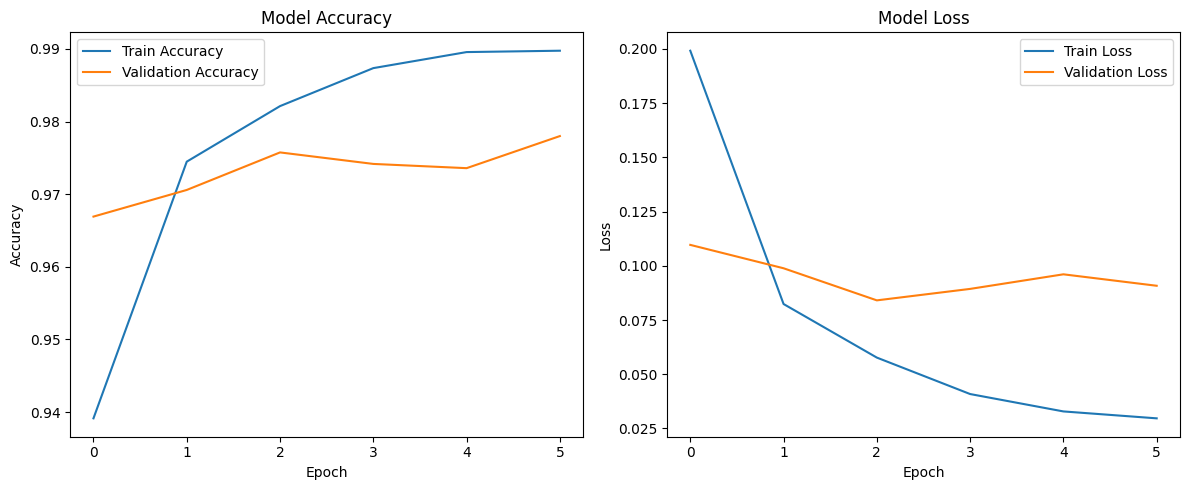

In [6]:
model = tf.keras.models.Sequential(
    [
        layers.Dense(1024, activation='relu'),
#        layers.Dropout(0.5),
#        layers.Dense(2048, activation='relu'),
#        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])

history = model.fit(x_train, y_train, batch_size=32, epochs=6, verbose=2, validation_split=0.2)
model.evaluate(x_test, y_test, batch_size=32, verbose=2)


# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
img_size = 28
labels = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
import matplotlib.pyplot as plt

def predict(img):
    # Extract and process image data
    img_data = img['composite']
    alpha_channel = img_data[..., 3]


    idx = np.random.randint(0, len(x_test))
    img_data2 = x_test[idx].reshape(28, 28)

    img_data_resized = cv2.resize(alpha_channel, (img_size, img_size))

    # Normalize the image data
    img_data_normalized = img_data_resized / 255.0

    # Reshape the image data to match the model's expected input shape
    img_data_flattened = img_data_normalized.reshape(1, 784)

    # Make predictions
    preds = model.predict(img_data_flattened)[0]

    # Return the predictions and the preprocessed image
    return {label: float(pred) for label, pred in zip(labels, preds)}, img_data2, img_data_normalized

# Define and launch the Gradio interface
interface = gr.Interface(fn=predict,
                         inputs="sketchpad",
                         outputs=[gr.Label(num_top_classes=3), gr.Image(type="numpy", width=280, height=280), gr.Image(type="numpy", width=280, height=280)])
interface.launch(debug=True)



Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://39be9f40d556fcaedb.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 21ms/step


In [ ]:
def classify(input):
    prediction = model.predict(input.reshape(1, 28, 28)).tolist()[0]
    return {str(i): prediction[i] for i in range(10)}


interface = gr.Interface(fn = classify,inputs="sketchpad", outputs=gr.Label(),
live=True)
interface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://f0a561f5d26da1c520.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 459, in call_prediction
    output = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 232, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1533, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1151, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    re

In [ ]:
iface.launch(debug=True)